# Image Jet Tagging Analysis - Leonardo 

In [10]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt

import seaborn as sns; sns.set()
#===========================
np.random.seed(123)

#=========================
def print_heatmap(data):
    heatmap = sns.heatmap(data)
    heatmap.set(xlabel='Pseudorapidity', ylabel='azimuthal angle')
    print(heatmap)
    
def predicted_values(output_values):
    predicted_values = []
    for probability in output_values:
        if probability[0] > probability[1]:
            predicted_values.append(0)
        else:
            predicted_values.append(1)
    return predicted_values
#===========================

! wget -c  https://github.com/raphaelmcobe/jet-classification/raw/master/signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt

signal_data = pd.read_table('signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt', header=None)

--2020-02-20 14:36:31--  https://github.com/raphaelmcobe/jet-classification/raw/master/signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt
Resolvendo github.com (github.com)... 18.231.5.6
Conectando-se a github.com (github.com)|18.231.5.6|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 302 Found
Localização: https://raw.githubusercontent.com/raphaelmcobe/jet-classification/master/signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt [redirecionando]
--2020-02-20 14:36:31--  https://raw.githubusercontent.com/raphaelmcobe/jet-classification/master/signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt
Resolvendo raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.92.133
Conectando-se a raw.githubusercontent.com (raw.githubusercontent.com)|151.101.92.133|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 416 Range Not Satisfiable

    O arquivo já foi completamente obtido; não há nada a ser feito.



# 1. Data Exploration
## 1.1. Signal Data

Data shape:  (11298, 626)
AxesSubplot(0.125,0.125;0.62x0.755)


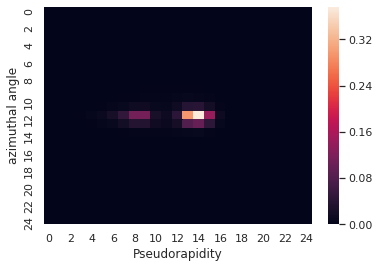

In [12]:
print('Data shape: ', signal_data.shape)
signal_data.drop(625, axis=1, inplace=True)
mean_s = signal_data.mean()
mean_s_matrix = mean_s.values
mean_s_matrix = mean_s_matrix.reshape((25,25))
print_heatmap(mean_s_matrix)

#===================
signal_data[625] = 1

## 1.2 Background data

In [13]:
! wget -c https://github.com/raphaelmcobe/jet-classification/raw/master/background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt
    
background_data = pd.read_table('background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt', header=None
                )

--2020-02-20 14:36:50--  https://github.com/raphaelmcobe/jet-classification/raw/master/background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt
Resolvendo github.com (github.com)... 18.231.5.6
Conectando-se a github.com (github.com)|18.231.5.6|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 302 Found
Localização: https://raw.githubusercontent.com/raphaelmcobe/jet-classification/master/background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt [redirecionando]
--2020-02-20 14:36:50--  https://raw.githubusercontent.com/raphaelmcobe/jet-classification/master/background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt
Resolvendo raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.92.133
Conectando-se a raw.githubusercontent.com (raw.githubusercontent.com)|151.101.92.133|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 416 Range Not Satisfiable

    O arquivo já foi completamente obtido; não há nada a ser feito.



AxesSubplot(0.125,0.125;0.62x0.755)


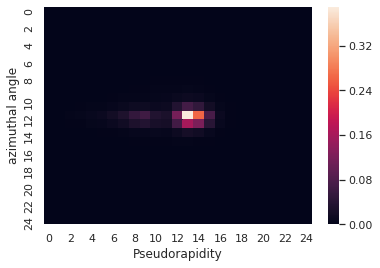

In [14]:
background_data.drop(625, axis=1, inplace=True)
mean_b = background_data.mean()
mean_b_matrix = mean_b.values
mean_b_matrix = mean_b_matrix.reshape((25,25))
print_heatmap(mean_b_matrix)
background_data[625] = 0

In [15]:
frames = [signal_data, background_data]
full_data = pd.concat(frames)
full_data = full_data.sample(frac=1).reset_index(drop=True)
full_data.rename(columns={625:'class'}, inplace=True)

In [16]:
print('full_data shape: ', full_data.shape)
print('full_data classes: ', full_data['class'].value_counts())

full_data shape:  (22596, 626)
full_data classes:  1    11298
0    11298
Name: class, dtype: int64


## 2. Preprocessing

In [17]:
data_target = full_data['class']
data_in = full_data.drop('class',axis=1)

train_x, test_x, train_y, test_y = train_test_split(data_in, data_target, test_size=.3)
#=========================================
train_y_tf = to_categorical(train_y.values, num_classes=2)
test_y_tf = to_categorical(test_y.values, num_classes=2)

## 3. Model evaluation
## 3.1 Model Example

In [118]:
# ANN======
model = Sequential()
model.add(Dense(units=8, activation='relu', input_dim=train_x.shape[1]))
model.add(Dense(units=2, activation='softmax'))
model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])

#------------------------------------------------------
model.fit(train_x.values, train_y_tf, batch_size=128, epochs=50, verbose=0)
score = model.evaluate(test_x.values, test_y_tf, verbose=0)
print(model.metrics_names)
print(score)
#--------------------------------------------------------

test_y_pred = model.predict(test_x.values, verbose=0)
#print(test_y_pred)
test_y_pred_values = predicted_values(test_y_pred)
test_y_values = predicted_values(test_y_tf)

#======================================
Falso_positivo = []
Falso_negativo = []
for i in range(0, len(test_y_values)):
    if test_y_values[i] == 0 and test_y_pred_values[i] ==1:
        Falso_positivo.append(i)
    elif test_y_values[i] == 1 and test_y_pred_values[i] == 0:
        Falso_negativo.append(i)
#========================================
print('Taxa de Falso positivo:', len(Falso_positivo)/len(test_y_values))
print('Taxa de Falso Negativo: ', len(Falso_negativo)/len(test_y_values))

['loss', 'accuracy']
[0.21374272101527558, 0.65599644]
Taxa de Falso positivo: 0.14485912376456705
Taxa de Falso Negativo:  0.1991444165806166


AxesSubplot(0.125,0.125;0.62x0.755)


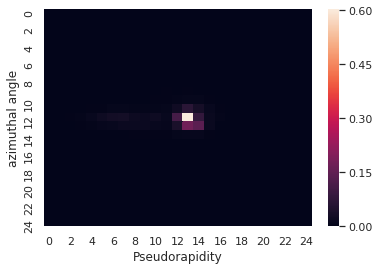

In [51]:
valores_FN = test_x.iloc[Falso_negativo,]
valores_FN_mean = valores_FN.mean().values
valores_FN_mean = valores_FN_mean.reshape((25,25))
print_heatmap(valores_FN_mean)


AxesSubplot(0.125,0.125;0.62x0.755)


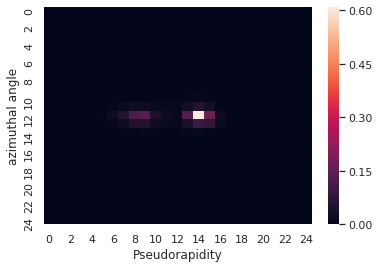

In [52]:

valores_FP = test_x.iloc[Falso_positivo,]
valores_FP_mean = valores_FP.mean().values
valores_FP_mean = valores_FP_mean.reshape((25,25))
print_heatmap(valores_FP_mean)

## 3.2 autoML 

In [336]:
data_target = full_data['class']
data_in = full_data.drop('class',axis=1)

train_x, test_x, train_y, test_y = train_test_split(data_in, data_target, test_size=.3)
#=========================================
train_y_tf = to_categorical(train_y.values, num_classes=2)
test_y_tf = to_categorical(test_y.values, num_classes=2)

In [337]:
from tpot import TPOTClassifier


tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2, random_state=42)
tpot.fit(train_x, train_y)
print(tpot.score(test_x, test_y))


Generation 1 - Current best internal CV score: 0.7596262769626525
Generation 2 - Current best internal CV score: 0.7596262769626525
Generation 3 - Current best internal CV score: 0.76588541739527
Generation 4 - Current best internal CV score: 0.7678455817961553
Generation 5 - Current best internal CV score: 0.7678455817961553

Best pipeline: GradientBoostingClassifier(MultinomialNB(ZeroCount(input_matrix), alpha=0.01, fit_prior=False), learning_rate=0.01, max_depth=10, max_features=0.7500000000000001, min_samples_leaf=12, min_samples_split=18, n_estimators=100, subsample=0.2)
0.7669272754093525


## 3.3 GradientBoostingClassifier

In [121]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(learning_rate=.1, max_depth=10, max_features=.9, min_samples_leaf=13, min_samples_split=6, n_estimators=100, subsample=.9)

gbc.fit(train_x, train_y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features=0.9, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=13, min_samples_split=6,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.9, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [119]:
test_y_pred = model.predict(test_x.values, verbose=0)
#print(test_y_pred)
test_y_pred_values = predicted_values(test_y_pred)
test_y_values = predicted_values(test_y_tf)

#======================================
Falso_positivo = []
Falso_negativo = []
for i in range(0, len(test_y_values)):
    if test_y_values[i] == 0 and test_y_pred_values[i] ==1:
        Falso_positivo.append(i)
    elif test_y_values[i] == 1 and test_y_pred_values[i] == 0:
        Falso_negativo.append(i)
#========================================
print('Taxa de Falso positivo:', len(Falso_positivo)/len(test_y_values))
print('Taxa de Falso Negativo: ', len(Falso_negativo)/len(test_y_values))

score = gbc.score(test_x, test_y)
print('Score: 'score)

Taxa de Falso positivo: 0.14485912376456705
Taxa de Falso Negativo:  0.1991444165806166
0.771500221271574


## 1.4 Keras


In [166]:
from tensorflow import keras
model = Sequential()
model.add(Dense(units=128, activation='relu',input_dim=train_x.shape[1]))
model.add(Dense(units=2, activation='softmax'))
model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])

#------------------------
data_target = full_data['class']
data_in = full_data.drop('class',axis=1)

train_x, test_x, train_y, test_y = train_test_split(data_in, data_target, test_size=.3)
#=========================================
train_y_tf = to_categorical(train_y.values, num_classes=2)
test_y_tf = to_categorical(test_y.values, num_classes=2)
#------------------------------------------------------

#------------------------------------------------------
model.fit(train_x.values, train_y_tf, batch_size=128, epochs=50, verbose=0)



In [168]:
#======================================
Falso_positivo = []
Falso_negativo = []
for i in range(0, len(test_y_values)):
    if test_y_values[i] == 0 and test_y_pred_values[i] ==1:
        Falso_positivo.append(i)
    elif test_y_values[i] == 1 and test_y_pred_values[i] == 0:
        Falso_negativo.append(i)
#========================================
score = model.evaluate(test_x.values, test_y_tf, verbose=0)
print(model.metrics_names)
print(score)
print('Taxa de Falso positivo:', len(Falso_positivo)/len(test_y_values))
print('Taxa de Falso Negativo: ', len(Falso_negativo)/len(test_y_values))


['loss', 'accuracy']
[0.21506239001660207, 0.65614396]
Taxa de Falso positivo: 0.14485912376456705
Taxa de Falso Negativo:  0.1991444165806166


## 1.5 Keras 2 tentativa

In [250]:
from tensorflow import keras
model = Sequential()
model.add(Dense(units=64, activation='relu',input_dim=train_x.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

#------------------------
data_target = full_data['class']
data_in = full_data.drop('class',axis=1)

train_x, test_x, train_y, test_y = train_test_split(data_in, data_target, test_size=.3)
#=========================================
train_y_tf = to_categorical(train_y.values, num_classes=2)
test_y_tf = to_categorical(test_y.values, num_classes=2)
#------------------------------------------------------

#------------------------------------------------------
model.fit(train_x.values, train_y_tf, batch_size=128, epochs=50, validation_data=(test_x.values,test_y_tf))



Train on 15817 samples, validate on 6779 samples
Epoch 1/50
15817/15817 [==============================] - 1s 44us/sample - loss: 0.6415 - accuracy: 0.6379 - val_loss: 0.5902 - val_accuracy: 0.6994
Epoch 2/50
15817/15817 [==============================] - 0s 19us/sample - loss: 0.5944 - accuracy: 0.6898 - val_loss: 0.5618 - val_accuracy: 0.7196
Epoch 3/50
15817/15817 [==============================] - 0s 21us/sample - loss: 0.5743 - accuracy: 0.7135 - val_loss: 0.5517 - val_accuracy: 0.7250
Epoch 4/50
15817/15817 [==============================] - 0s 19us/sample - loss: 0.5607 - accuracy: 0.7238 - val_loss: 0.5397 - val_accuracy: 0.7334
Epoch 5/50
15817/15817 [==============================] - 0s 20us/sample - loss: 0.5456 - accuracy: 0.7298 - val_loss: 0.5317 - val_accuracy: 0.7362
Epoch 6/50
15817/15817 [==============================] - 0s 18us/sample - loss: 0.5430 - accuracy: 0.7386 - val_loss: 0.5283 - val_accuracy: 0.7398
Epoch 7/50
15817/15817 [==============================] -

In [251]:
#======================================
Falso_positivo = []
Falso_negativo = []
for i in range(0, len(test_y_values)):
    if test_y_values[i] == 0 and test_y_pred_values[i] ==1:
        Falso_positivo.append(i)
    elif test_y_values[i] == 1 and test_y_pred_values[i] == 0:
        Falso_negativo.append(i)
#========================================
score = model.evaluate(test_x.values, test_y_tf, verbose=0)
print(model.metrics_names)
print(score)
print('Taxa de Falso positivo:', len(Falso_positivo)/len(test_y_values))
print('Taxa de Falso Negativo: ', len(Falso_negativo)/len(test_y_values))


['loss', 'accuracy']
[0.5043292398350062, 0.7651571]
Taxa de Falso positivo: 0.14485912376456705
Taxa de Falso Negativo:  0.1991444165806166


### 1.3.2 Keras 3 tentativa

In [274]:
from tensorflow import keras
from keras import regularizers
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
model = Sequential()
model.add(Dense(units=8, activation='relu',input_dim=train_x.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=2, activation='softmax'))
#sgd = SGD(lr=.01,decay=1e-6,momentum=.9,nesterov=True)
model.compile(loss='logcosh', optimizer='rmsprop', metrics=['accuracy'])

#------------------------
data_target = full_data['class']
data_in = full_data.drop('class',axis=1)

train_x, test_x, train_y, test_y = train_test_split(data_in, data_target, test_size=.3)
#=========================================
train_y_tf = to_categorical(train_y.values, num_classes=2)
test_y_tf = to_categorical(test_y.values, num_classes=2)
#------------------------------------------------------

#------------------------------------------------------
model.fit(train_x.values, train_y_tf, batch_size=128, epochs=20, validation_data=(test_x.values,test_y_tf))



Train on 15817 samples, validate on 6779 samples
Epoch 1/20
15817/15817 [==============================] - 1s 40us/sample - loss: 0.1149 - accuracy: 0.6033 - val_loss: 0.1038 - val_accuracy: 0.6733
Epoch 2/20
15817/15817 [==============================] - 0s 16us/sample - loss: 0.1040 - accuracy: 0.6594 - val_loss: 0.0939 - val_accuracy: 0.7122
Epoch 3/20
15817/15817 [==============================] - 0s 14us/sample - loss: 0.0993 - accuracy: 0.6801 - val_loss: 0.0900 - val_accuracy: 0.7224
Epoch 4/20
15817/15817 [==============================] - 0s 16us/sample - loss: 0.0963 - accuracy: 0.6932 - val_loss: 0.0882 - val_accuracy: 0.7219
Epoch 5/20
15817/15817 [==============================] - 0s 15us/sample - loss: 0.0939 - accuracy: 0.7048 - val_loss: 0.0865 - val_accuracy: 0.7327
Epoch 6/20
15817/15817 [==============================] - 0s 18us/sample - loss: 0.0924 - accuracy: 0.7077 - val_loss: 0.0845 - val_accuracy: 0.7377
Epoch 7/20
15817/15817 [==============================] -

In [275]:
#======================================
Falso_positivo = []
Falso_negativo = []
for i in range(0, len(test_y_values)):
    if test_y_values[i] == 0 and test_y_pred_values[i] ==1:
        Falso_positivo.append(i)
    elif test_y_values[i] == 1 and test_y_pred_values[i] == 0:
        Falso_negativo.append(i)
#========================================
score = model.evaluate(test_x.values, test_y_tf, verbose=0)
print(model.metrics_names)
print(score)
print('Taxa de Falso positivo:', len(Falso_positivo)/len(test_y_values))
print('Taxa de Falso Negativo: ', len(Falso_negativo)/len(test_y_values))


['loss', 'accuracy']
[0.0805314548576295, 0.75025815]
Taxa de Falso positivo: 0.14485912376456705
Taxa de Falso Negativo:  0.1991444165806166


## 1.3.3 Keras 3 tentativa

In [286]:

model = Sequential()
model.add(Dense(units=64, activation='relu',input_dim=train_x.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=2, activation='softmax'))
#sgd = SGD(lr=.01,decay=1e-6,momentum=.9,nesterov=True)
model.compile(loss='logcosh', optimizer='rmsprop', metrics=['accuracy'])

#------------------------
data_target = full_data['class']
data_in = full_data.drop('class',axis=1)

train_x, test_x, train_y, test_y = train_test_split(data_in, data_target, test_size=.3)
#=========================================
train_y_tf = to_categorical(train_y.values, num_classes=2)
test_y_tf = to_categorical(test_y.values, num_classes=2)
#------------------------------------------------------

#------------------------------------------------------
model.fit(train_x.values, train_y_tf, batch_size=128, epochs=20, validation_data=(test_x.values,test_y_tf))



Train on 15817 samples, validate on 6779 samples
Epoch 1/20
15817/15817 [==============================] - 1s 40us/sample - loss: 0.1083 - accuracy: 0.6374 - val_loss: 0.0964 - val_accuracy: 0.6783
Epoch 2/20
15817/15817 [==============================] - 0s 20us/sample - loss: 0.0964 - accuracy: 0.6896 - val_loss: 0.0901 - val_accuracy: 0.7149
Epoch 3/20
15817/15817 [==============================] - 0s 19us/sample - loss: 0.0913 - accuracy: 0.7087 - val_loss: 0.0869 - val_accuracy: 0.7278
Epoch 4/20
15817/15817 [==============================] - 0s 18us/sample - loss: 0.0884 - accuracy: 0.7219 - val_loss: 0.0854 - val_accuracy: 0.7324
Epoch 5/20
15817/15817 [==============================] - 0s 18us/sample - loss: 0.0866 - accuracy: 0.7275 - val_loss: 0.0839 - val_accuracy: 0.7362
Epoch 6/20
15817/15817 [==============================] - 0s 18us/sample - loss: 0.0850 - accuracy: 0.7337 - val_loss: 0.0830 - val_accuracy: 0.7392
Epoch 7/20
15817/15817 [==============================] -

In [287]:
#======================================
Falso_positivo = []
Falso_negativo = []
for i in range(0, len(test_y_values)):
    if test_y_values[i] == 0 and test_y_pred_values[i] ==1:
        Falso_positivo.append(i)
    elif test_y_values[i] == 1 and test_y_pred_values[i] == 0:
        Falso_negativo.append(i)
#========================================
score = model.evaluate(test_x.values, test_y_tf, verbose=0)
print(model.metrics_names)
print(score)
print('Taxa de Falso positivo:', len(Falso_positivo)/len(test_y_values))
print('Taxa de Falso Negativo: ', len(Falso_negativo)/len(test_y_values))

['loss', 'accuracy']
[0.07775211117602253, 0.76028913]
Taxa de Falso positivo: 0.14485912376456705
Taxa de Falso Negativo:  0.1991444165806166


# 1.3.4 Keras 4 tentativa

In [353]:

model = Sequential()
model.add(Dense(units=train_x.shape[1], activation='relu',input_dim=train_x.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(units=254, activation='relu'))
#model.add(Dropout(0.2))

#model.add(Dense(units=254, activation='relu'))

model.add(Dense(units=2, activation='sigmoid'))
#sgd = SGD(lr=.01,decay=1e-6,momentum=.9,nesterov=True)
model.compile(loss='logcosh', optimizer='rmsprop', metrics=['accuracy'])

#------------------------
data_target = full_data['class']
data_in = full_data.drop('class',axis=1)

train_x, test_x, train_y, test_y = train_test_split(data_in, data_target, test_size=.3)
#=========================================
train_y_tf = to_categorical(train_y.values, num_classes=2)
test_y_tf = to_categorical(test_y.values, num_classes=2)
#------------------------------------------------------

#------------------------------------------------------
model.fit(train_x.values, train_y_tf, batch_size=128, epochs=20, validation_data=(test_x.values,test_y_tf))


Train on 15817 samples, validate on 6779 samples
Epoch 1/20
15817/15817 [==============================] - 1s 72us/sample - loss: 0.0945 - accuracy: 0.6912 - val_loss: 0.0892 - val_accuracy: 0.7106
Epoch 2/20
15817/15817 [==============================] - 1s 48us/sample - loss: 0.0855 - accuracy: 0.7285 - val_loss: 0.0886 - val_accuracy: 0.7128
Epoch 3/20
15817/15817 [==============================] - 1s 48us/sample - loss: 0.0824 - accuracy: 0.7408 - val_loss: 0.0826 - val_accuracy: 0.7411
Epoch 4/20
15817/15817 [==============================] - 1s 45us/sample - loss: 0.0801 - accuracy: 0.7493 - val_loss: 0.0819 - val_accuracy: 0.7452
Epoch 5/20
15817/15817 [==============================] - 1s 45us/sample - loss: 0.0785 - accuracy: 0.7569 - val_loss: 0.0837 - val_accuracy: 0.7357
Epoch 6/20
15817/15817 [==============================] - 1s 43us/sample - loss: 0.0772 - accuracy: 0.7596 - val_loss: 0.0803 - val_accuracy: 0.7534
Epoch 7/20
15817/15817 [==============================] -

In [352]:
#======================================
Falso_positivo = []
Falso_negativo = []
for i in range(0, len(test_y_values)):
    if test_y_values[i] == 0 and test_y_pred_values[i] ==1:
        Falso_positivo.append(i)
    elif test_y_values[i] == 1 and test_y_pred_values[i] == 0:
        Falso_negativo.append(i)
#========================================
score = model.evaluate(test_x.values, test_y_tf, verbose=0)
print(model.metrics_names)
print(score)
print('Taxa de Falso positivo:', len(Falso_positivo)/len(test_y_values))
print('Taxa de Falso Negativo: ', len(Falso_negativo)/len(test_y_values))

NameError: name 'test_y_values' is not defined

## 1.3.5 Keras tentativa 5

In [94]:
from keras.optimizers import RMSprop
model = Sequential()
model.add(Dense(units=train_x.shape[1], activation='relu',input_dim=train_x.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=512, activation='elu'))
#model.add(Dropout(0.5))
#model.add(Dense(units=128, activation='elu'))
model.add(Dense(units=2, activation='softmax'))
#rms = RMSprop(0.001)
model.compile(loss='logcosh', optimizer='rmsprop', metrics=['accuracy'])

#------------------------
data_target = full_data['class']
data_in = full_data.drop('class',axis=1)

train_x, test_x, train_y, test_y = train_test_split(data_in, data_target, test_size=.3)
#=========================================
train_y_tf = to_categorical(train_y.values, num_classes=2)
test_y_tf = to_categorical(test_y.values, num_classes=2)
#------------------------------------------------------

#------------------------------------------------------
model.fit(train_x.values, train_y_tf, batch_size=128, epochs=20, validation_data=(test_x.values,test_y_tf))


Train on 15817 samples, validate on 6779 samples
Epoch 1/20
15817/15817 [==============================] - 1s 81us/sample - loss: 0.0971 - accuracy: 0.6830 - val_loss: 0.0871 - val_accuracy: 0.7275
Epoch 2/20
15817/15817 [==============================] - 1s 58us/sample - loss: 0.0872 - accuracy: 0.7239 - val_loss: 0.0816 - val_accuracy: 0.7414
Epoch 3/20
15817/15817 [==============================] - 1s 57us/sample - loss: 0.0842 - accuracy: 0.7338 - val_loss: 0.0831 - val_accuracy: 0.7380
Epoch 4/20
15817/15817 [==============================] - 1s 57us/sample - loss: 0.0805 - accuracy: 0.7470 - val_loss: 0.0797 - val_accuracy: 0.7537
Epoch 5/20
15817/15817 [==============================] - 1s 60us/sample - loss: 0.0791 - accuracy: 0.7568 - val_loss: 0.0787 - val_accuracy: 0.7598
Epoch 6/20
15817/15817 [==============================] - 1s 56us/sample - loss: 0.0777 - accuracy: 0.7620 - val_loss: 0.0783 - val_accuracy: 0.7594
Epoch 7/20
15817/15817 [==============================] -

In [95]:
#======================================
#Falso_positivo = []
#Falso_negativo = []
#for i in range(0, len(test_y_values)):
 #   if test_y_values[i] == 0 and test_y_pred_values[i] ==1:
  #      Falso_positivo.append(i)
   # elif test_y_values[i] == 1 and test_y_pred_values[i] == 0:
    #    Falso_negativo.append(i)
#========================================
score = model.evaluate(test_x.values, test_y_tf, verbose=0)
print(model.metrics_names)
print(score)
#print('Taxa de Falso positivo:', len(Falso_positivo)/len(test_y_values))
#print('Taxa de Falso Negativo: ', len(Falso_negativo)/len(test_y_values))

['loss', 'accuracy']
[0.0764439488441161, 0.774008]


## 1.3.6 Keras 6 tentativa


In [349]:
from keras.optimizers import RMSprop
model = Sequential()
model.add(Dense(units=train_x.shape[1], activation='relu',input_dim=train_x.shape[1]))
model.add(Dropout(0.5))
#============================================================
model.add(Dense(units=512,activation='elu'))
model.add(Dropout(0.5))
#=========================================================
model.add(Dense(units=512, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='elu'))
model.add(Dropout(0.5))
#=========================================================
model.add(Dense(units=2, activation='tanh'))
model.compile(loss='logcosh', optimizer='rmsprop', metrics=['acc'])
#=========================================================
data_target = full_data['class']
data_in = full_data.drop('class',axis=1)
train_x, test_x, train_y, test_y = train_test_split(data_in, data_target, test_size=.3)
#=========================================
train_y_tf = to_categorical(train_y.values, num_classes=2)
test_y_tf = to_categorical(test_y.values, num_classes=2)
#==========================================================
model.fit(train_x.values, train_y_tf, batch_size=128, epochs=20, validation_data=(test_x.values,test_y_tf))
#----------------------------------------------------------
#========================================

score = model.evaluate(test_x.values, test_y_tf, verbose=0)
print(model.metrics_names)
print(score)


Train on 15817 samples, validate on 6779 samples
Epoch 1/20
15817/15817 [==============================] - 2s 97us/sample - loss: 0.1094 - acc: 0.6668 - val_loss: 0.0936 - val_acc: 0.7162
Epoch 2/20
15817/15817 [==============================] - 1s 71us/sample - loss: 0.0945 - acc: 0.7183 - val_loss: 0.0883 - val_acc: 0.7289
Epoch 3/20
15817/15817 [==============================] - 1s 70us/sample - loss: 0.0906 - acc: 0.7357 - val_loss: 0.0887 - val_acc: 0.7246
Epoch 4/20
15817/15817 [==============================] - 1s 69us/sample - loss: 0.0868 - acc: 0.7485 - val_loss: 0.0838 - val_acc: 0.7365
Epoch 5/20
15817/15817 [==============================] - 1s 68us/sample - loss: 0.0834 - acc: 0.7613 - val_loss: 0.0835 - val_acc: 0.7405
Epoch 6/20
15817/15817 [==============================] - 1s 67us/sample - loss: 0.0822 - acc: 0.7653 - val_loss: 0.0818 - val_acc: 0.7460
Epoch 7/20
15817/15817 [==============================] - 1s 69us/sample - loss: 0.0799 - acc: 0.7744 - val_loss: 0.0

In [ ]:
train_x.shape[1]